In [28]:
from scipy.signal import argrelextrema, find_peaks
from scipy.spatial.distance import cdist, squareform, pdist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

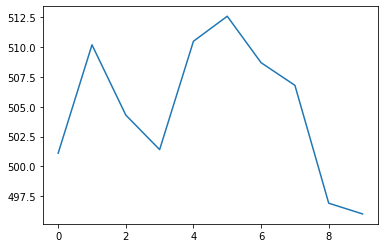

In [304]:
close = 500 + np.cumsum(0.1 + np.random.randint(-10, 10, 10))
plt.plot(close)

### Create function for apply
- merge code into function
- takes df and returns df with same index and more columsn

In [367]:
def cdist_growth(a, b):
    # Compute simple growth rate from a to b
    diff = b - a
    return np.divide(diff, a)

def entry_exit_labeler(close_df, direction, min_growth, max_duration):
    close = close_df.values
    if direction == "short":
        close = close * -1
    
    # Find all peaks and valleys
    max_idx = find_peaks(close)[0]
    min_idx = find_peaks(-close)[0]
    
    # Mask valleys & peaks
    min_mask = np.zeros(close.shape, dtype=bool)
    min_mask[min_idx] = True
    max_mask = np.zeros(close.shape, dtype=bool)
    max_mask[max_idx] = True
    
    # Compute joint max x min joint mask
    if direction == "long":
        minmax_mask = np.outer(min_mask, max_mask)
    elif direction == "short":
        minmax_mask = np.outer(max_mask, min_mask)

    # Compute distance matrix between all close points
    dist_matrix = cdist(close.reshape(-1, 1), close.reshape(-1, 1), metric=cdist_growth)
    
    # Scope dist_matrix to distances > min_threshold
    growth_mask = (dist_matrix - min_growth) > 0
    dist_matrix = dist_matrix*growth_mask
    
    # Limit to max_duration & remove lower triangle
    dist_matrix = np.tril(dist_matrix, k=max_duration)
    dist_matrix = np.triu(dist_matrix)
    
    # Scope to only peak & valley points
    dist_matrix = minmax_mask*dist_matrix
    dist_matrix
    
    # Get idx for non zero distances
    good_entry_idx, good_exit_idx = np.where(dist_matrix > 0)
    
    # Populate DataFrame and return
    if direction == "long":
        col_names=["&good_long_entry", "&good_long_exit", "&fake_long_entry", "&fake_long_exit"]
    elif direction == "short":
        col_names=["&good_short_entry", "&good_short_exit", "&fake_short_entry", "&fake_short_exit"]
    df = pd.DataFrame(columns=col_names, index=close_df.index)
    df[col_names] = "No"

    # Entries & Exits
    if direction == "long":
        entry_idx = min_idx
        exit_idx = max_idx
    elif direction == "short":
        entry_idx = max_idx
        exit_idx = min_idx
        
    df.loc[[i for i in entry_idx if i not in good_entry_idx], col_names[2]] = "Yes"
    df.loc[good_entry_idx, col_names[0]] = "Yes"
    df.loc[[i for i in exit_idx if i not in good_exit_idx], col_names[3]] = "Yes"
    df.loc[good_exit_idx, col_names[1]] = "Yes"

    return df

In [368]:
close_ = 500 + np.cumsum(0.1 + np.random.randint(-10, 10, 100))
test_df = pd.DataFrame(close_, columns=["close"], index=np.arange(len(close_)))
results = entry_exit_labeler(test_df["close"], direction="short", min_growth=0.01, max_duration=5)
results

,&good_short_entry,&good_short_exit,&fake_short_entry,&fake_short_exit
0,No,No,No,No
1,No,No,No,No
2,No,No,No,No
3,No,No,No,Yes
4,No,No,No,No
...,...,...,...,...
95,No,No,No,No
96,No,Yes,No,No
97,No,No,Yes,No
98,No,No,No,Yes


<AxesSubplot:>

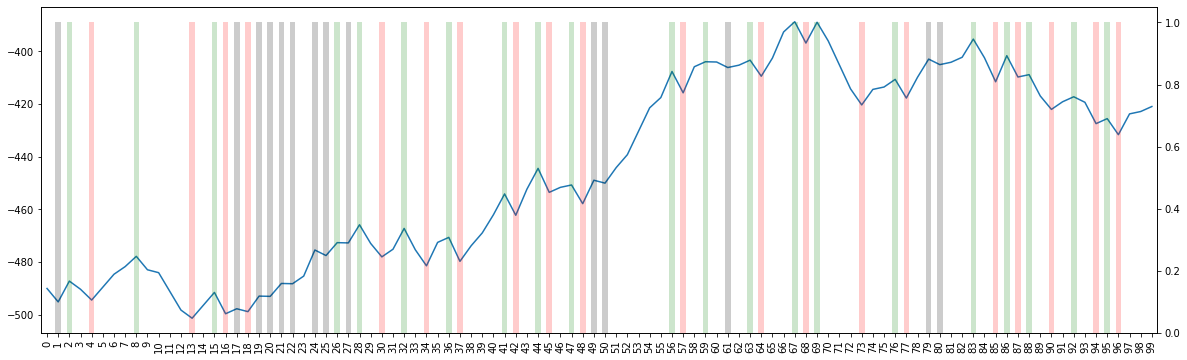

In [360]:
results["close"].plot(figsize=(20, 6))
results["&good_entry"].plot(secondary_y=True, kind="bar", alpha=0.2, color="green")
results["&good_exit"].plot(secondary_y=True, kind="bar", alpha=0.2, color="red")
results["&fake_entry"].plot(secondary_y=True, kind="bar", alpha=0.2, color="black")
results["&fake_exit"].plot(secondary_y=True, kind="bar", alpha=0.2, color="black")

In [ ]:
["&good_entry", "&good_exit", "&fake_entry", "&fake_exit"]

### Steps
- identify all peaks and valleys for close
- mask close to show just peaks and valleys
- compute cdist for all points in close
- mask dist that is > max_distance
- identify distances that are > min_threshold
- get idx for those points
- label those points as good entries and exists
- label all other peak/valleys as fake entries/exits

In [88]:
close = 500 + np.cumsum(0.1 + np.random.randint(-10, 10, 20))
close

array([503.1, 509.2, 507.3, 514.4, 512.5, 512.6, 503.7, 506.8, 510.9,
       503. , 512.1, 508.2, 508.3, 513.4, 504.5, 509.6, 515.7, 523.8,
       529.9, 529. ])

In [89]:
# Find all peaks and valleys
peak_idx = find_peaks(close)[0]
valley_idx = find_peaks(-close)[0]
valley_idx, peak_idx

(array([ 2,  4,  6,  9, 11, 14]), array([ 1,  3,  5,  8, 10, 13, 18]))

In [90]:
# Mask valleys
valley_mask = np.zeros(close.shape, dtype=bool)
valley_mask[valley_idx] = True
valley_mask

array([False, False,  True, False,  True, False,  True, False, False,
        True, False,  True, False, False,  True, False, False, False,
       False, False])

In [91]:
peak_mask = np.zeros(close.shape, dtype=bool)
peak_mask[peak_idx] = True
peak_mask

array([False,  True, False,  True, False,  True, False, False,  True,
       False,  True, False, False,  True, False, False, False, False,
        True, False])

In [102]:
peak_valley_mask = np.outer(valley_mask, peak_mask)
peak_valley_mask

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False,  True, False,  True, False,  True, False, False,  True,
        False,  True, False, False,  True, False, False, False, False,
         True, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False,  True, False,  True, False,  True, False, False,  True,
        False,  True, False, False,  True, False, False, False, False,
         True, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [Fa

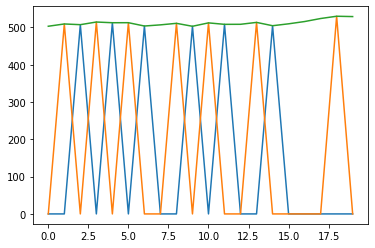

In [231]:
# Check we're on track
plt.plot(valley_mask*close)
plt.plot(peak_mask*close)
plt.plot(close)

In [105]:
# Compute distance matrix
def cdist_growth(a, b):
    diff = b - a
    return np.divide(diff, a)

dist_matrix = cdist(close.reshape(-1, 1), close.reshape(-1, 1), metric=cdist_growth)
dist_matrix

array([[ 0.        ,  0.01212483,  0.00834824,  0.02246074,  0.01868416,
         0.01888293,  0.00119261,  0.0073544 ,  0.01550388, -0.00019877,
         0.01788909,  0.01013715,  0.01033592,  0.02047307,  0.00278275,
         0.0129199 ,  0.02504472,  0.0411449 ,  0.05326973,  0.05148082],
       [-0.01197958,  0.        , -0.00373134,  0.0102121 ,  0.00648075,
         0.00667714, -0.01080126, -0.00471328,  0.00333857, -0.01217596,
         0.00569521, -0.00196386, -0.00176748,  0.00824823, -0.00923016,
         0.00078555,  0.01276512,  0.02867243,  0.040652  ,  0.03888452],
       [-0.00827912,  0.00374532,  0.        ,  0.01399566,  0.01025034,
         0.01044747, -0.00709639, -0.00098561,  0.00709639, -0.00847625,
         0.00946186,  0.0017741 ,  0.00197122,  0.01202444, -0.00551942,
         0.00453381,  0.01655825,  0.03252513,  0.04454958,  0.04277548],
       [-0.02196734, -0.01010886, -0.01380249,  0.        , -0.00369362,
        -0.00349922, -0.02080093, -0.01477449, -

In [110]:
# Scope to distances > min_threshold
min_growth = 0.02

growth_mask = (dist_matrix - min_growth) > 0
dist_matrix = dist_matrix*growth_mask

dist_matrix

array([[ 0.        ,  0.        ,  0.        ,  0.02246074,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.        ,
         0.        ,  0.        ,  0.        ,  0.02047307,  0.        ,
         0.        ,  0.02504472,  0.0411449 ,  0.05326973,  0.05148082],
       [-0.        ,  0.        , -0.        ,  0.        ,  0.        ,
         0.        , -0.        , -0.        ,  0.        , -0.        ,
         0.        , -0.        , -0.        ,  0.        , -0.        ,
         0.        ,  0.        ,  0.02867243,  0.040652  ,  0.03888452],
       [-0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.        , -0.        ,  0.        , -0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.        ,
         0.        ,  0.        ,  0.03252513,  0.04454958,  0.04277548],
       [-0.        , -0.        , -0.        ,  0.        , -0.        ,
        -0.        , -0.        , -0.        , -

In [70]:
np.tril(dist_matrix, k=5)

array([[ 0. ,  0.1,  0.2,  2.7,  0.6,  4.5,  0. ,  0. ,  0. ,  0. ],
       [ 0.1,  0. ,  0.1,  2.8,  0.7,  4.4,  2.5,  0. ,  0. ,  0. ],
       [ 0.2,  0.1,  0. ,  2.9,  0.8,  4.3,  2.4, 11.5,  0. ,  0. ],
       [ 2.7,  2.8,  2.9,  0. ,  2.1,  7.2,  5.3, 14.4, 20.5,  0. ],
       [ 0.6,  0.7,  0.8,  2.1,  0. ,  5.1,  3.2, 12.3, 18.4, 20.5],
       [ 4.5,  4.4,  4.3,  7.2,  5.1,  0. ,  1.9,  7.2, 13.3, 15.4],
       [ 2.6,  2.5,  2.4,  5.3,  3.2,  1.9,  0. ,  9.1, 15.2, 17.3],
       [11.7, 11.6, 11.5, 14.4, 12.3,  7.2,  9.1,  0. ,  6.1,  8.2],
       [17.8, 17.7, 17.6, 20.5, 18.4, 13.3, 15.2,  6.1,  0. ,  2.1],
       [19.9, 19.8, 19.7, 22.6, 20.5, 15.4, 17.3,  8.2,  2.1,  0. ]])

In [111]:
# Limit to max_duration
max_duration = 5
dist_matrix = np.tril(dist_matrix, k=max_duration)

# Remove lower triangle
dist_matrix = np.triu(dist_matrix)

dist_matrix

array([[ 0.        ,  0.        ,  0.        ,  0.02246074,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.        ,  0.        ,  0.        ,
         0.        , -0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.        , -0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        -0.        , -0.        , -0.        , -

In [113]:
# Scope using peak valley mask
scoped_dist_matrix = peak_valley_mask*dist_matrix
scoped_dist_matrix

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.        ,  0.        ,  0.        ,
         0.        , -0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.        , -0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        -0.        , -0.        , -0.        , -

In [114]:
# Get idx for non zero distances
v, p = np.where(scoped_dist_matrix > 0)
v, p

(array([ 9, 14]), array([13, 18]))

In [134]:
df = pd.DataFrame(close, columns=["close"])
df[["&long_entry", "&long_exit", "&fake_long_entry", "&fake_long_exit"]] = "No"

# Long Entries
df.loc[[i for i in valley_idx if i not in v], "&fake_long_entry"] = "Yes"
df.loc[v, "&long_entry"] = "Yes"

# Long Exits
df.loc[[i for i in peak_idx if i not in p], "&fake_long_exit"] = "Yes"
df.loc[p, "&long_exit"] = "Yes"

df

,close,&long_entry,&long_exit,&fake_long_entry,&fake_long_exit
0,503.1,No,No,No,No
1,509.2,No,No,No,Yes
2,507.3,No,No,Yes,No
3,514.4,No,No,No,Yes
4,512.5,No,No,Yes,No
5,512.6,No,No,No,Yes
6,503.7,No,No,Yes,No
7,506.8,No,No,No,No
8,510.9,No,No,No,Yes
9,503.0,Yes,No,No,No


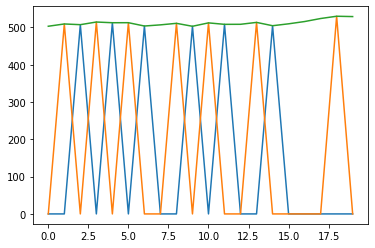

In [117]:
# Check we're on track
plt.plot(valley_mask*close)
plt.plot(peak_mask*close)
plt.plot(close)

In [141]:
test_df = pd.DataFrame(close, columns=["close"])

def test(df):
    return df/2

test_df[["close"]].apply(test)

,close
0,251.55
1,254.60
2,253.65
3,257.20
4,256.25
5,256.30
6,251.85
7,253.40
8,255.45
9,251.50


### Old way

,close,&long_entry,&long_exit,&fake_long_entry,&fake_long_exit,&long_exist
0,503.1,No,No,No,No,NaN
1,509.2,No,No,No,No,NaN
2,507.3,No,No,No,No,NaN
3,514.4,No,No,No,No,NaN
4,512.5,No,No,No,No,NaN
5,512.6,No,No,No,No,NaN
6,503.7,No,No,No,No,NaN
7,506.8,No,No,No,No,NaN
8,510.9,No,No,No,No,NaN
9,503.0,Yes,No,No,No,NaN


In [ ]:
close = 500 + np.cumsum(0.1 + np.random.randint(-10, 10, 30))
peak_idx = find_peaks(close)[0]
valley_idx = find_peaks(-close)[0]

plt.figure(figsize=(20,7))
plt.plot(close)
plt.bar(peak_idx, close[peak_idx], color="red", alpha=0.2)
plt.bar(valley_idx, close[valley_idx], color="green", alpha=0.2)

In [ ]:
# Ensure no peak before valley
print(peak_idx, valley_idx)

peak_idx = np.array([i for i in peak_idx if i > valley_idx.min()])
print(peak_idx)

In [ ]:
def cdist_growth(a, b):
    diff = b - a
    return np.divide(diff, a)

dist = cdist(close[valley_idx].reshape(-1, 1), close[peak_idx].reshape(-1, 1), metric=cdist_growth)
dist

In [ ]:
# Subtract min_threshold and go to upper triangle
min_threshold = 0.02
dist = dist - min_threshold
dist = np.triu(dist, k=0)
dist

In [ ]:
# Compute index distance
def simple_distance(a, b):
    diff = b - a
    return diff

idx_dist = cdist(valley_idx.reshape(-1, 1), peak_idx.reshape(-1, 1), metric=simple_distance)
idx_dist = np.triu(idx_dist, k=0)
idx_dist

In [ ]:
# Check min_distance and set to zero
min_distance = 5
idx_dist = idx_dist*(idx_dist < min_distance)
idx_dist

In [ ]:
# Reduce distance matrix to values where idx_dist is > 0
# What below means.
# All zero values are "fake_entries" and "fake_exists"
# Non zero are good "entries" and "exists"
# Cleanup needed to ensure "good" trumps "fake"

dist = dist*(idx_dist > 0)*(dist > 0)
dist

In [ ]:
(1000*dist).astype(int)

In [ ]:
p, v = np.where(dist > 0)
v, p

In [ ]:
valley_idx[v], peak_idx[p]

In [ ]:
valley_idx, peak_idx

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(close)
plt.bar(peak_idx, close[peak_idx], color="red", alpha=0.2)
plt.bar(valley_idx, close[valley_idx], color="green", alpha=0.2)

In [319]:
peak_idx, valley_idx

(array([3, 8]), array([2, 7]))

In [ ]:
# Need to access idx where growth is above min_threshold
for i, row in enumerate(dist):
    for j, value in enumerate(row):
        print(valley_idx[i], peak_idx[j], value)

In [ ]:
max_peaks = argrelextrema(df["close"].values, lambda a, b: a < b, order=15)[0]
min_peaks = argrelextrema(df["close"].values, lambda a, b: a > b, order=15)[0]

df["maxima"] = 0
df.loc[max_peaks, "maxima"] = 1

df["minima"] = 0
df.loc[min_peaks, "minima"] = 1

df["close"].plot(figsize=(20,8))
df["maxima"].plot(secondary_y=True)
df["minima"].plot(secondary_y=True)

In [ ]:
df[df["minima"].isin([1, 2])]

In [ ]:
df[180:300]["close"].plot(figsize=(20,8))
df[180:300]["maxima"].plot(secondary_y=True)
df[180:300]["minima"].plot(secondary_y=True)
df[180:300]["smeared-maxima"].plot(secondary_y=True)

In [ ]:
from scipy.signal import find_peaks
df = pd.DataFrame(1000 + np.cumsum(0.1 + np.random.randint(-10, 10, 100)), columns=['close'])

In [359]:
np.triu(dist, k=0)

array([[0.00226244, 0.0088441 , 0.01768819],
       [0.        , 0.00842928, 0.01726974],
       [0.        , 0.        , 0.02527973]])

In [ ]:
def find_peak_valley(df, min_threshold, min_distance):
    
    df = df.copy()
    peak = find_peaks(df)[0]
    valley = find_peaks(-df)[0]
    
    df["long_exit"] = 0
    df["long_entry"] = 0
    df["fake_long_exit"] = 0
    df["fake_long_entry"] = 0
    df.loc[valley, "fake_long_entry"] = 1
    
    for i, v in df.loc[valley, :].iterrows():
        for j, p in df.loc[peak, :].iterrows():
            v_value = valleys.loc[i]["close"]
            p_value = peaks.loc[j]["close"]
            if j < i:
                print(f"Wrong order: {i}, {j}")
                continue
            elif j - i > min_distance:
                print(f"min distance exceeded {j - i}")
                break
            elif (p_value - v_value) / v_value > min_threshold:
                print(f"threshold exceeded: {v_value}, {p_value}")
                df.loc[i, "long_entry"] = 1
                df.loc[i, "fake_long_entry"] = 0
                df.loc[j, "long_exit"] = 1
                break
            else:
                print(f"Insufficient peak found: {v_value}, {p_value}")
                df.loc[j, "fake_long_exit"] = 1

    # Ensure no conflicting labels
    df.loc[df["long_exit"] == 1, "fake_long_exit"] = 0
    
df.apply(find_peak_valley, min_threshold=0.2, min_distance=10)

In [ ]:
df

In [ ]:
min_distance = 10
min_threshold = 0.02

peak = find_peaks(df["close"].values)[0]
valley = find_peaks(-df["close"].values)[0]

df["long_exit"] = 0
df["long_entry"] = 0
df["fake_long_exit"] = 0
df["fake_long_entry"] = 0
df.loc[valley, "fake_long_entry"] = 1

df["peak"] = 0
df.loc[peak, "peak"] = 1
df["valley"] = 0
df.loc[valley, "valley"] = 1

In [ ]:
# Find all peaks within min_distance
peaks = df[df["peak"] == 1]
valleys = df[df["valley"] == 1]
print(peaks.shape)
valleys.shape

for i, v in valleys.iterrows():
    for j, p in peaks.iterrows():
        v_value = valleys.loc[i]["close"]
        p_value = peaks.loc[j]["close"]
        if j < i:
            print(f"Wrong order: {i}, {j}")
            continue
        elif j - i > min_distance:
            print(f"min distance exceeded {j - i}")
            break
        elif (p_value - v_value) / v_value > min_threshold:
            print(f"threshold exceeded: {v_value}, {p_value}")
            df.loc[i, "long_entry"] = 1
            df.loc[i, "fake_long_entry"] = 0
            df.loc[j, "long_exit"] = 1
            break
        else:
            print(f"Insufficient peak found: {v_value}, {p_value}")
            df.loc[j, "fake_long_exit"] = 1

# Ensure no conflicting labels
df.loc[df["long_exit"] == 1, "fake_long_exit"] = 0

In [ ]:
df["close"].plot(figsize=(20,8))
df["long_entry"].plot(secondary_y=True, kind="bar", color="green", alpha=0.2)
df["long_exit"].plot(secondary_y=True, kind="bar", color="green", alpha=0.2)
df["fake_long_entry"].plot(secondary_y=True, kind="bar", color="red", alpha=0.2)
df["fake_long_exit"].plot(secondary_y=True, kind="bar", color="red", alpha=0.2)

In [ ]:
df = pd.DataFrame(1000 + np.cumsum(0.1 + np.random.randint(-10, 10, 10000)), columns=['close'])

# Find all good entries and exits for longs
min_distance = 10
min_threshold = 0.02

peak = find_peaks(df["close"].values)[0]
valley = find_peaks(-df["close"].values)[0]
print(peak.shape)
print(valley.shape)

df["&long_exit"] = "No"
df["&long_entry"] = "No"
df["&fake_long_exit"] = "No"
df["&fake_long_entry"] = "No"
df.loc[valley, "&fake_long_entry"] = "Yes"

for i, v in df.loc[valley, :].iterrows():
    for j, p in df.loc[peak, :].iterrows():
        v_value = df.loc[i, "close"]
        p_value = df.loc[j, "close"]
        if j < i:
            print(f"Wrong order: {i}, {j}")
            continue
        elif j - i > min_distance:
            print(f"min distance exceeded {j - i}")
            break
        elif (p_value - v_value) / v_value > min_threshold:
            print(f"threshold exceeded: {v_value}, {p_value}")
            df.loc[i, "&long_entry"] = "Yes"
            df.loc[j, "&long_exit"] = "Yes"
            break
        else:
            print(f"Insufficient peak found: {v_value}, {p_value}")
            df.loc[j, "&fake_long_exit"] = "Yes"

# Ensure no conflicting labels
df.loc[df["&long_exit"] == "Yes", "&fake_long_exit"] = "No"

In [ ]:
df.head(50)

In [ ]:
from catboost import CatBoostClassifier

df["dummy"] = df["close"] *4
X_train = df[["close", "dummy"]]
y_train = df[["&long_exit", "&long_entry", "&fake_long_exit", "&fake_long_entry"]]

clf = CatBoostClassifier(loss_function="MultiLogloss")
clf.fit(X_train, y_train)

In [ ]:
clf.predict(X_train)

In [ ]:
df[["long_exit", "long_entry", "fake_long_exit", "fake_long_entry"]].replace(replace_rules, inplace=True)
y_train

In [ ]:
y_train

In [ ]:
# Longs
threshold = 0.01
max_distance = 20
seeking = "valley"
df["valley_target"] = 0
df["peak_target"] = 0

for i, r in minmax_df.iterrows():
    if seeking == "valley":
        print("seeking valley")
        # Find valley
        if r["valley"] == 1:
            valley_value = r["close"]
            valley_idx = i
            print(f"found valley with value: {valley_value} at {i}")
            seeking = "peak"
        continue
        
    if seeking == "peak":
        print("seeking peak")
        # Check if max_distance exceeded
        if i - valley_idx > max_distance:
            print("max distance exceeded")
            seeking = "valley"
            continue
        # Compare to next peak
        if r["peak"] == 1:
            peak_value = r["close"]
            pct_delta = (peak_value - valley_value)/valley_value
            print(f"found peak with delta: {pct_delta}")
            if pct_delta > threshold:
                print(f"confirmed peak at {i}")
                df.at[valley_idx, "valley_target"] = 1
                df.at[i, "peak_target"] = 1
                seeking = "valley"

In [ ]:
df["close"].plot(figsize=(20,8))
df["peak_target"].plot(secondary_y=True)
df["valley_target"].plot(secondary_y=True)

In [ ]:
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist, pdist, squareform

peak_values = df[df["peak"] == 1]["close"].values.reshape(-1,1)
valley_values = df[df["valley"] == 1]["close"].values.reshape(-1,1)

def custom_calc(x, y):
    return (y-x)/x

d = cdist(peak_values, valley_values, metric=custom_calc)

d

In [ ]:
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist, pdist, squareform

close_prices = df["close"].values.reshape(-1,1)

def custom_calc(x, y):
    return (y-x)/x

d = pdist(close_prices, metric=custom_calc)

squareform(d).shape

In [ ]:
df["valley"] == 1

In [ ]:
# Define Min & Max binary indicators
min_peaks = argrelextrema(df["close"].values, np.less, order=20)
max_peaks = argrelextrema(df["close"].values, np.greater, order=20)

df["&s-minima"] = 0
df["&s-maxima"] = 0
df["real-minima"] = 0
df["real-maxima"] = 0

df["pct_ahead"] = df["close"].shift(-1) / df["close"]
df["pct_be"] = df["close"].shift(-1) / df["close"]

proximity_tolerance = 0.1

for mp in min_peaks[0]:
    df.at[mp, "real-minima"] = 1
    df.at[mp, "&s-minima"] = 1
    min_peak_value = df.at[mp, "close"]
    if abs(df.at[mp - 1, "close"] / min_peak_value - 1) < proximity_tolerance:
        df.at[mp - 1, "&s-minima"] = 1
    if abs(df.at[mp + 1, "close"] / min_peak_value - 1) < proximity_tolerance:
        df.at[mp + 1, "&s-minima"] = 1

for mp in max_peaks[0]:
    df.at[mp, "real-maxima"] = 1
    df.at[mp, "&s-maxima"] = 1
    max_peak_value = df.at[mp, "close"]
    if abs(df.at[mp - 1, "close"] / max_peak_value - 1) < proximity_tolerance:
        df.at[mp - 1, "&s-maxima"] = 1
    if abs(df.at[mp + 1, "close"] / max_peak_value - 1) < proximity_tolerance:
        df.at[mp + 1, "&s-maxima"] = 1

In [14]:
df

,close,maxima,minima
0,1000.1,0,0
1,993.2,0,0
2,999.3,0,0
3,996.4,0,0
4,987.5,0,0
...,...,...,...
995,647.6,0,0
996,653.7,0,0
997,656.8,0,0
998,654.9,0,0


In [167]:
df.loc[:, "long_exit"] == 1

0     False
1     False
2     False
3     False
4     False
      ...  
95    False
96    False
97    False
98    False
99    False
Name: long_exit, Length: 100, dtype: bool

In [ ]:
df.head(50)

In [ ]:
from scipy.signal import find_peaks

In [ ]:
df = yf.download("AAPL")["Close"][8000:].reset_index()
df

In [ ]:
max_peaks, _ = find_peaks(df["Close"], prominence=2, wlen=400)
min_peaks, _ = find_peaks(-df["Close"], prominence=2, wlen=400)

In [ ]:
df["maxima"] = 0
df.loc[max_peaks, "maxima"] = 1

df["minima"] = 0
df.loc[min_peaks, "minima"] = 1

df["Close"].plot(figsize=(20,8))
df["maxima"].plot(secondary_y=True)
df["minima"].plot(secondary_y=True)

In [ ]:
df["max_peak"] = 0
df.loc[peak_idx, "max_peak"] = df.loc[peak_idx, "close"]

In [ ]:
df["close"].plot(figsize=(20,10), ylim=(850, 1100))
df["max_peak"].plot()

In [ ]:
import yfinance as yf